In [2]:
from IPython.display import clear_output 


! pip install gdown
clear_output()

In [3]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.models as models
from torchvision import transforms,datasets
import seaborn as sns

import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
import random
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.nn.functional import kl_div, softmax, log_softmax
import torch.optim as optim
import torch.utils.data as data
from os.path import exists, join, split
from os import listdir
from os.path import join
from PIL import Image
import random
import sys
from numpy.random import default_rng
import zipfile
from tqdm import tqdm

import matplotlib.pyplot as plt 
from skimage.io import imread, imsave
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,Dataset


In [4]:
!pip install syft==0.2.9
#After installion, Restarting the runtime is required

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import gdown
url = 'https://drive.google.com/uc?id=1MAakvkGyUNiqZNKnnpsreVGDCJnS5Czx' 
output_X = 'X_UCM.pickle'
gdown.download(url, output_X, quiet=False)

url_y = 'https://drive.google.com/uc?id=1mSLimMpZXqYuUJgL4D4bhtnlwzhKTgOh' 
output_Y = 'Y_UCM.pickle'
gdown.download(url_y, output_Y, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1MAakvkGyUNiqZNKnnpsreVGDCJnS5Czx
To: /content/X_UCM.pickle
100%|██████████| 413M/413M [00:01<00:00, 248MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mSLimMpZXqYuUJgL4D4bhtnlwzhKTgOh
To: /content/Y_UCM.pickle
100%|██████████| 8.55k/8.55k [00:00<00:00, 14.4MB/s]


'Y_UCM.pickle'

In [6]:
import pickle

pickle_in = open("./X_UCM.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("./Y_UCM.pickle","rb")
Y = pickle.load(pickle_in)

# Data from Drive

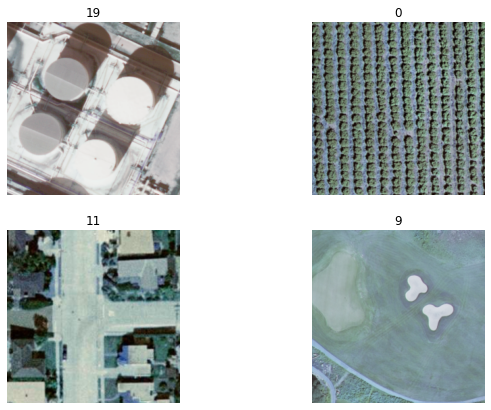

In [7]:
import cv2
from matplotlib import pyplot as plt
import random

fig = plt.figure(figsize=(10, 7))

rows = 2
columns = 2


for i in range (0,4):
    fig.add_subplot(rows, columns, i+1)
    rand = random.randint(0, 2000)
    plt.imshow(X[rand])
    plt.axis('off')
    plt.title(Y[rand])

#Class Distribution Visualization

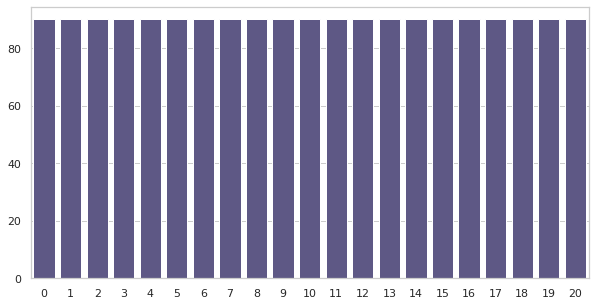

In [20]:
unique, counts = np.unique(Y_train, return_counts=True)



sns.set(rc={'figure.figsize':(10,5)})

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=unique, y= counts,color='#58508d')


In [9]:
print("Number of classes: "+ str(len(unique)))
print("Dataset size: "+ str(len(unique)*100))

Number of classes: 21
Dataset size: 2100


#Creation of multiple Workers




In [10]:
import syft as sy  

hook = sy.TorchHook(torch)  
worker01 = sy.VirtualWorker(hook, id="worker-01")  
worker02 = sy.VirtualWorker(hook, id="worker-02")  
worker03 = sy.VirtualWorker(hook, id="worker-03")  
worker04 = sy.VirtualWorker(hook, id="worker-04")  
worker05 = sy.VirtualWorker(hook, id="worker-05")  



In [11]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 100
        self.epochs = 50
        self.lr = 0.003
        self.momentum = 0.9
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10
        self.save_model = True 

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")



In [12]:
device

device(type='cuda')

#Splitting Dataset into Train and test

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size=0.1, random_state=42,stratify=Y)

In [14]:
X_train.shape

(1890, 256, 256, 3)

#Dataloaders & CNN

In [15]:
class CustomDatasetLoader(Dataset): # Custom data loader from splitted dataset
    def __init__(self, data_feature, data_target,transform,phase='label'):
        self.data_feature = data_feature
        self.data_target = data_target
        self.transform = transform
        self.phase=phase

    def __len__(self):
        return len(self.data_feature)

    def __getitem__(self, index):
        if self.phase=='label':
            data_feature = self.transform(Image.fromarray(np.uint8(self.data_feature[index])))
            data_target =  self.data_target[index]
            return data_feature, data_target
        else:
            data_feature = self.data_feature[index].float()
            return data_feature

train_transform = transforms.Compose([
                       transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_transform =transforms.Compose([ transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

                   ])

train_dataset = CustomDatasetLoader(X_train, Y_train, transform=train_transform)
test_dataset = CustomDatasetLoader(X_test, Y_test, transform=test_transform)

federated_train_loader = sy.FederatedDataLoader( train_dataset.federate((worker01, worker02,worker03,worker04,worker05)), # distribute the dataset across all the workers, now it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.test_batch_size, shuffle=True)

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5, 1,1)
        self.conv2 = nn.Conv2d(12,20,5,1,1)
        self.fc1 = nn.Linear(20*62*62, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 21)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 20*62*62)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)



In [17]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # send the model to the right location
        data, target = data.to(device), target.to(device).long()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get() # get the model back
        if batch_idx % args.log_interval == 0:
            loss = loss.get() # <-- get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(train_loader) * args.batch_size, #batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [18]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [19]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) 

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "best_model.pt")

Train Epoch: 1 [0/1920 (0%)]	Loss: 3.047342
Train Epoch: 1 [640/1920 (33%)]	Loss: 3.046113
Train Epoch: 1 [1280/1920 (67%)]	Loss: 3.029185

Test set: Average loss: 3.0315, Accuracy: 19/210 (9%)

Train Epoch: 2 [0/1920 (0%)]	Loss: 3.033190
Train Epoch: 2 [640/1920 (33%)]	Loss: 3.030977
Train Epoch: 2 [1280/1920 (67%)]	Loss: 3.024540

Test set: Average loss: 3.0210, Accuracy: 14/210 (7%)

Train Epoch: 3 [0/1920 (0%)]	Loss: 3.010582
Train Epoch: 3 [640/1920 (33%)]	Loss: 3.029037
Train Epoch: 3 [1280/1920 (67%)]	Loss: 3.005464

Test set: Average loss: 3.0090, Accuracy: 15/210 (7%)

Train Epoch: 4 [0/1920 (0%)]	Loss: 3.025631
Train Epoch: 4 [640/1920 (33%)]	Loss: 3.021082
Train Epoch: 4 [1280/1920 (67%)]	Loss: 2.986964

Test set: Average loss: 2.9937, Accuracy: 17/210 (8%)

Train Epoch: 5 [0/1920 (0%)]	Loss: 2.992486
Train Epoch: 5 [640/1920 (33%)]	Loss: 2.976961
Train Epoch: 5 [1280/1920 (67%)]	Loss: 2.950980

Test set: Average loss: 2.9730, Accuracy: 20/210 (10%)

Train Epoch: 6 [0/1920 (

Remarks:
Was able to achieve 40% accuracy with 50 epochs. With more epochs and hyperparameter tuning, better accuracy can be achieved.